In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

path = "/media/sarah/storage/Data/Douglas Bakkum/sampledata/"
file_name = path+'footprint.mat'
map2_name = "/media/sarah/storage/Data/Douglas Bakkum/transformed.mat"
mat_contents = sio.loadmat(file_name)
map2_image = sio.loadmat(map2_name)

In [2]:
# Load electrode coordinates
n_elec = 206
x_coord = mat_contents['footprint'][0][0][6][0]
y_coord = mat_contents['footprint'][0][0][7][0]

# Load average traces
n_samples = 101
n_traces = mat_contents['footprint'][0][0][5][0]
tot_traces = mat_contents['footprint'][0][0][4]

In [3]:
# Sorting the data

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, n_elec)]

# Sorting in x-dir

sorted_xind = np.argsort(x_coord)

# Sorting in y-dir

sorted_yind = np.zeros((n_elec-2))

for i in range(12):
    xx = y_coord[sorted_xind][17*i:17*(i+1)]
    #print xx
    #print x_coord[sorted_xind][17*i:17*(i+1)]
    sort_xx = np.argsort(xx) + int(17*i)
    #print sort_xx
    #print y_coord[sorted_xind][sort_xx]
    sorted_yind[17*i:17*(i+1)] = sort_xx

sorted_yind = sorted_yind.astype(int)

# Sort all the data

sorted_xcoord = x_coord[sorted_xind][sorted_yind]
sorted_ycoord = y_coord[sorted_xind][sorted_yind]

sorted_ntraces = n_traces[sorted_xind][sorted_yind]
sorted_tottraces = tot_traces[:,sorted_xind][:,sorted_yind]

In [4]:
# Distance between to points

def distance_inter_elec(x1, x2):
    dx = x1[0]-x2[0]
    dy = x1[1]-x2[1]
    return np.abs(dx), np.abs(dy), np.sqrt(dx**2+dy**2)

#print distance_inter_elec([sorted_xcoord[5], sorted_ycoord[5]], [sorted_xcoord[50], sorted_ycoord[50]])

# Electric field at a point 

def field_on_grid(pos, xcoord, ycoord, V, t):
    xp = [xcoord[pos], ycoord[pos]]
    ne = len(xcoord)
    Ex = 0
    Ey = 0
    for i in [x for x in xrange(ne) if x != pos]:
        xc = [xcoord[i], ycoord[i]]
        dx = distance_inter_elec(xp, xc)[0]
        dy = distance_inter_elec(xp, xc)[1]
        dV = V[t, pos] - V[t, i]
        if dx == 0:
            ex = 0
        else:
            ex = dV/dx
        if dy == 0:
            ey = 0
        else:
            ey = dV/dy
        #print ex, ey
        Ex += ex
        Ey += ey
        
    return [Ex, Ey]

#fie = field_on_grid(54, sorted_xcoord, sorted_ycoord, sorted_tottraces, 10)

In [5]:
ne  = len(x_coord)

Ex = np.zeros((n_elec))
Ey = np.zeros((n_elec))

for i in range(n_elec):
    e = field_on_grid(i, x_coord, y_coord, tot_traces, 50)
    Ex[i] = e[0]
    Ey[i] = e[1]

In [6]:
# With interpolation

ny = 17

# One array with all the y values
y1 = sorted_ycoord[:17]
y2 = sorted_ycoord[17:34]
y_full = np.zeros((2*ny))
y_full[::2] = y1
y_full[1::2] = y2

# Data points
x_d = x_coord
y_d = y_coord

# Define the grid
x_m = sorted_xcoord[::17]
y_m = y_full
X_m, Y_m = np.meshgrid(x_m, y_m)

# Grid the data.
Ex_interp = griddata((x_d, y_d), Ex, (X_m, Y_m), method='cubic')
Ey_interp = griddata((x_d, y_d), Ey, (X_m, Y_m), method='cubic')

In [13]:
%matplotlib notebook

# Plot
fig = plt.figure(figsize=(8,10))
ax = fig.add_subplot(111)
color = np.log(np.hypot(Ex_interp, Ey_interp))
ax.streamplot(X_m, Y_m, Ex_interp, Ey_interp, color=color, linewidth=1, cmap=plt.cm.inferno,
              density=2, arrowstyle='->', arrowsize=1.5)
ax.set_aspect('equal')
#ax.set_ylim((2100, 1750))
#ax.set_ylim((1750, 2100))
#ax.set_xlim((250,450))

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


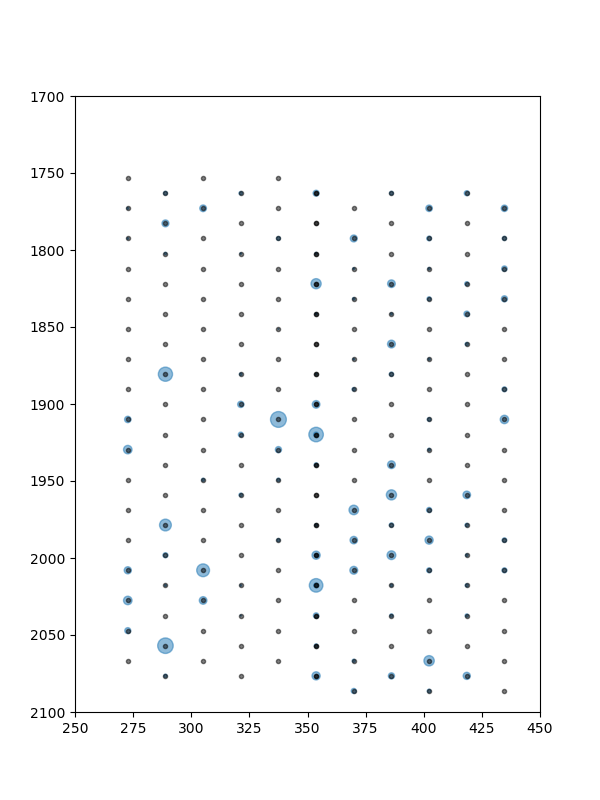

<IPython.core.display.Javascript object>


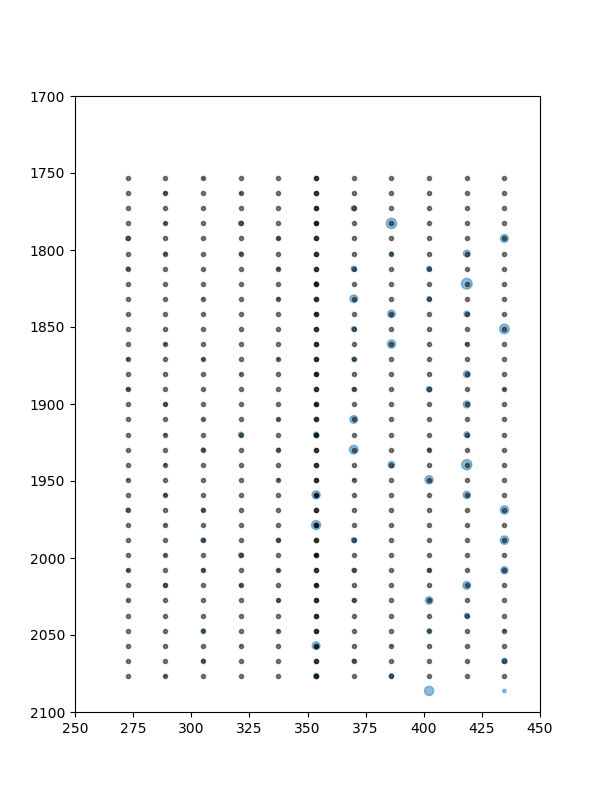

In [14]:
plt.figure(figsize=(6,8))
plt.plot(x_coord, y_coord, 'k.', alpha=0.5)
#plt.plot(X_m, Y_m, 'k.')
#plt.scatter(x_d, y_d, Ex_interp, 'g', alpha=0.5)
plt.scatter(sorted_xcoord, sorted_ycoord, Ex, alpha=0.5)
plt.ylim((2100, 1700))
plt.xlim((250,450))

plt.figure(figsize=(6,8))
#plt.plot(x_coord, y_coord, 'ro', alpha=0.3)
plt.plot(X_m, Y_m, 'k.', alpha=0.5)
plt.scatter(x_d, y_d, Ex_interp, alpha=0.5)
#plt.scatter(sorted_xcoord, sorted_ycoord, Ex, alpha=0.5)
plt.ylim((2100, 1700))
plt.xlim((250,450))


plt.show()